# Statistical information on the data

In [2]:
from xml.etree import ElementTree
from xml.dom import minidom
import collections

import os

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [2]:
class Country_stats:
    def __init__(self, country_name, images_per_class, total_images, total_images_with_detection):
        self.country_name = country_name
        self.images_per_class = images_per_class
        self.total_images = total_images
        self.total_images_with_detection = total_images_with_detection
        self.number_of_labels = sum(images_per_class.values())
        


In [3]:
def get_stats(base_path, country_name, imageSetsPath):
    # the number of total images and total labels.
    images_per_class= {}
    total_images = 0
    total_images_with_detection = 0
        
    file_list = [filename for filename in os.listdir(base_path) if not filename.startswith('.')]

    for file in file_list:

        total_images = total_images + 1
        if file =='.DS_Store':
            pass
        else:
            infile_xml = open(base_path + file)
            tree = ElementTree.parse(infile_xml)
            root = tree.getroot()
            image_path = root.find('filename').text.strip('.jpg')

            crack_in_image = False
            for obj in root.iter('object'):
                crack_in_image = True
                cls_name = obj.find('name').text
                path = imageSetsPath + f'/{cls_name}_images.txt'
                with open(path, 'a+') as f:
                    f.write(f'{image_path}\n')
                if cls_name in images_per_class.keys():
                    images_per_class[cls_name] += 1
                else:
                    images_per_class[cls_name] = 1
            if crack_in_image:
                total_images_with_detection += 1
    return Country_stats(country_name, images_per_class, total_images, total_images_with_detection)


In [4]:
base_path = os.getcwd()

# We ignore "Repair" and "Block crack"

imageSetsPath = os.getcwd() + '/ImageSets/'
isExist = os.path.exists(imageSetsPath)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(imageSetsPath)
   print("The new directory is created!")

for file_name in os.listdir(imageSetsPath):
   path = imageSetsPath+file_name
   with open(path, 'w+') as f:
      f.write("")


The new directory is created!


In [5]:
dataset_root = '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022'
#dataset_root = base_path

countries = ["China_Drone", "China_MotorBike", "Czech", "India", "Japan", "Norway", "United_States"]
classes = {"D00": "Longitude cracks", "D10": "Lateral", "D20": "Alligator", "D40": "Pothole"}
country_stats = []

for country in countries:
    src_dir_annot = dataset_root +'/'+ country +'/train' + '/annotations/' + "xmls/"
    src_dir_img = dataset_root +'/'+ country +'/train' + '/images/'
    country_stats.append(get_stats(src_dir_annot, country, imageSetsPath))

In [6]:
def display_stats(country_stat: Country_stats):
    print("Country: ", country_stat.country_name)
    print("# of images：" + str(country_stat.total_images))
    print("# of labels：" + str(country_stat.number_of_labels))
    print('# of images with object: ' + str(country_stat.total_images_with_detection))

    for cls in country_stat.images_per_class.keys():
        print(str(cls) + ' : ' + str(country_stat.images_per_class[cls]))
    sns.set_palette("winter", len(country_stat.images_per_class))
    sns.barplot(x=list(country_stat.images_per_class.keys()), y= list(country_stat.images_per_class.values())).set(title=country_stat.country_name)


Country:  China_Drone
# of images：2401
# of labels：3840
# of images with object: 2396
D10 : 1263
Repair : 769
D00 : 1426
D20 : 293
D40 : 86
Block crack : 3
Country:  China_MotorBike
# of images：1977
# of labels：4927
# of images with object: 1977
D00 : 2678
D10 : 1096
D20 : 641
Repair : 277
D40 : 235
Country:  Czech
# of images：2829
# of labels：1745
# of images with object: 1072
D00 : 988
D10 : 399
D40 : 197
D20 : 161
Country:  India
# of images：7706
# of labels：8203
# of images with object: 3785
D20 : 2021
D43 : 57
D40 : 3187
D44 : 1062
D01 : 179
D00 : 1555
D10 : 68
D11 : 45
D50 : 28
D0w0 : 1
Country:  Japan
# of images：10506
# of labels：24754
# of images with object: 9712
D50 : 3553
D44 : 3995
D20 : 6199
D00 : 4049
D40 : 2243
D10 : 3979
D43 : 736
Country:  Norway
# of images：8161
# of labels：11229
# of images with object: 2914
D00 : 8570
D40 : 461
D10 : 1730
D20 : 468
Country:  United_States
# of images：4805
# of labels：11014
# of images with object: 4805
D00 : 6750
D10 : 3295
D20 : 8

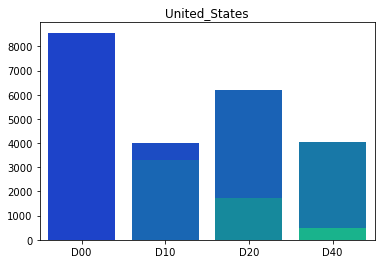

In [9]:
images_per_class = {'D10': 0, 'D40': 0, 'D00': 0, 'D20': 0}
total_images=number_of_labels=total_images_with_detection = 0
for x in country_stats:
    display_stats(x)
    total_images += x.total_images
    number_of_labels += x.number_of_labels
    total_images_with_detection += x.total_images_with_detection
    for cls in images_per_class:
        images_per_class[cls] += x.images_per_class[cls]


All countries:
# of images：38385
# of labels：65712
# of images with object: 26661
D10 : 11830
D40 : 6544
D00 : 26016
D20 : 10617


[Text(0.5, 1.0, 'All countries')]

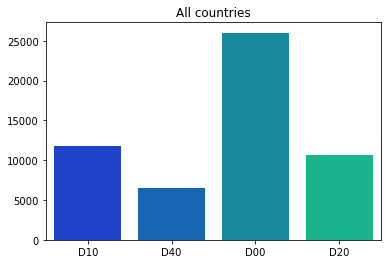

In [10]:
print("All countries:")
print("# of images：" + str(total_images))
print("# of labels：" + str(number_of_labels))
print('# of images with object: ' + str(total_images_with_detection))

for cls in images_per_class.keys():
    print(str(cls) + ' : ' + str(images_per_class[cls]))
sns.set_palette("winter", len(images_per_class))
sns.barplot(x=list(images_per_class.keys()), y= list(images_per_class.values())).set(title="All countries")

# Visualize some images

In [11]:
import cv2
import random

In [12]:
def draw_images(image_file, folder_path):
    gov = image_file.split('_')[0]
    img = cv2.imread(folder_path + '/train'+'/images/' + image_file.split('.')[0] + '.jpg')
    
    infile_xml = open(folder_path + '/train' + '/annotations/xmls/' +image_file)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

In [17]:
numb_of_images_shown = 3
folder_path = dataset_root + '/China_Drone'
for damageType in images_per_class.keys():
    tmp = []

    file = open(os.getcwd()+ '/ImageSets/%s_images.txt' %damageType, 'r')

    for line in file:
        line = line.strip('\n')
        tmp.append(line + '.xml')
        
    random.shuffle(tmp)
    fig = plt.figure(figsize=(15,15))
    
    for number, image in enumerate(tmp[0:numb_of_images_shown]):
        img = draw_images(image, folder_path)
        plt.subplot(1,numb_of_images_shown,number+1)
        plt.axis('off')
        plt.title('The image including ' + damageType)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/projects/vc/courses/TDT17/2022/open/RDD2022/China_Drone/train/annotations/xmls/United_States_001067.xml'

<Figure size 1080x1080 with 0 Axes>

# Convert VOC into YOLO

### Move all training images and annotations into one folder for all countries

In [19]:
if not os.path.exists('./datasets/RDD2022/annotations/'):
    os.makedirs(os.getcwd() +'/datasets/RDD2022/annotations')
if not os.path.exists('./datasets/RDD2022/images/'):
    os.makedirs(os.getcwd() +'/datasets/RDD2022/images')

In [3]:
new_dataset_dir = os.getcwd() +'/datasets/RDD2022/'
dest_dir_annot = os.getcwd() +'/datasets/RDD2022/annotations'
dest_dir_imgs = os.getcwd() +'/datasets/RDD2022/images'

In [22]:
import shutil
dataset_root = "/cluster/projects/vc/courses/TDT17/2022/open/RDD2022"
#dataset_root = base_path
countries = ["China_Drone", "China_MotorBike", "Czech", "India", "Japan", "Norway", "United_States"]
classes = {"D00": "Longitude cracks", "D10": "Lateral", "D20": "Alligator", "D40": "Pothole"}


country_stats = []

for country in countries:
    src_dir_annot = dataset_root +'/'+ country +'/train' + '/annotations/' + "xmls"
    src_dir_img = dataset_root +'/'+ country +'/train' + '/images'
    file_list = [filename.strip('.xml') for filename in os.listdir(src_dir_annot)]
    for file in file_list:
        annot_path = src_dir_annot + '/' + file +'.xml'
        annot_dest = dest_dir_annot + '/' + file +'.xml'
        img_path = src_dir_img + '/' + file+ '.jpg'
        img_dest = dest_dir_imgs + '/' + file+ '.jpg'
        shutil.copyfile(annot_path, annot_dest)
        shutil.copyfile(img_path, img_dest)

### Convert annotations to yolo format

In [4]:
from xml2yolo import xml_to_yolo
input_dir = dest_dir_annot
label_dir = 'datasets/RDD2022/lables'
image_dir = dest_dir_imgs
valid_classes = ["D10", "D40", "D00", "D20"]
xml_to_yolo(input_dir, label_dir, image_dir, valid_classes)

# Get all train images


In [5]:
import glob
import random
files = glob.glob(os.path.join(image_dir, '*.jpg'))
random.shuffle(files)

folders = {"train": 0.8, "val": 0.2}
check_sum = sum([folders[x] for x in folders])
assert check_sum == 1.0, "Split proportion is not equal to 1.0"

In [6]:
split_point = round(len(files)*folders['train'])

path = new_dataset_dir + 'train.txt'
with open(path, 'w+') as file:
    file.write('\n'.join(str(line) for line in files[:split_point]))

path = new_dataset_dir + 'val.txt'
with open(path, 'w+') as file:
    file.write('\n'.join(str(line) for line in files[split_point:]))

print('# of train: ', split_point)
print('# of val: ', str(len(files)-split_point))


# of train:  30708
# of val:  7677


# Create dataset yaml file

In [ ]:
dataset_root_dir = new_dataset_dir
train = new_dataset_dir + 'train.txt'
val = new_dataset_dir + 'val.txt'

classes = valid_classes # ["D10", "D40", "D00", "D20"]




# Convert VOC to YOLO

# Model